In [12]:
#%pip install pandas
#%pip install pymssql
#%pip install matplotlib
#%pip install sklearn

In [51]:
import pandas as pd
import pymssql
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.optimize import curve_fit
import datetime
import seaborn as sns

In [2]:
def ms_sql_con():
    sql_name = 'voice_ai'
    sql_server = '10.2.4.124'
    sql_login = 'ICECORP\\1c_sql'

    with open('sql.pass','r') as file:
        sql_pass = file.read().replace('\n', '')
        file.close()

    return pymssql.connect(
            server = sql_server,
            user = sql_login,
            password = sql_pass,
            database = sql_name,
        )

In [3]:
def read_sql(query):
    return pd.read_sql(query, con=ms_sql_con(), parse_dates=None)

In [ ]:
def phrases_per_hour(date_from, date_to, phrase):
    query = "select month(record_date) as m,  day(record_date) as d, DATEPART(HOUR, record_date) as h, count(id) as c" 
    query += " from transcribations where "
    query += " record_date > '"+date_from+"' and "
    query += " record_date < '"+date_to+"' and "
    query += " text like '%"+phrase+"%' "
    query += " group by month(record_date), day(record_date), DATEPART(HOUR, record_date)"
    query += " order by month(record_date), day(record_date), DATEPART(HOUR, record_date);"
    df = read_sql(query)
    
    df.drop(['m', 'd'], axis = 1, inplace = True)
    df = df.groupby(df.h).median()
    df.reset_index(level=0, inplace=True)
    
    plt.bar(df.h, df.c)
    plt.show()

In [ ]:
def silence_timing(date_from, date_to):

    def convert_false(val):
        return not val
    
    query = "select"
    query += " sum(end_time - start) as time,"
    query += " DATEPART(HOUR, record_date) as h,"
    query += " linkedid,"
    query += " side,"
    query += " duration"
    query += " from transcribations"
    query += " where"
    query += " record_date > '"+date_from+"' and "
    query += " record_date < '"+date_to+"' and"
    query += " duration > 0 "
    query += " group by record_date, linkedid, side, duration"
    query += " order by linkedid, side;"
    df = read_sql(query)
    df['a'] = df.time*df.side
    df.side = df.side.apply(convert_false)
    df['b'] = df.time*df.side
    df.drop(['time', 'side'], axis = 1, inplace = True)
    df = df.groupby(['h', 'linkedid', 'duration']).sum()
    df.reset_index(level=0, inplace=True)
    df.reset_index(level=0, inplace=True)
    df.reset_index(level=0, inplace=True)
    df.drop(['linkedid'], axis = 1, inplace = True)
    df.reset_index(level=0, inplace=True)
    df['part_a'] = df.a/df.duration
    df['part_b'] = df.b/df.duration
    df['part_silence'] = 1 - df.part_a - df.part_b
    df.drop(['duration', 'a', 'b'], axis = 1, inplace = True)
    df = df.groupby(['h']).mean()
    df.reset_index(level=0, inplace=True)
    df.drop(['index'], axis = 1, inplace = True)
    df.sort_values(['h'], inplace = True)
    df.plot(x = 'h', y = ['part_a', 'part_b', 'part_silence'], style = '.')    

In [ ]:
phrases_per_hour('2021-03-04 00:00:00', '2021-03-05 00:00:00', 'операторы заняты')

In [ ]:
silence_timing('2021-03-01 00:00:00', '2021-03-02 00:00:00')

In [ ]:
### developing

In [4]:
query = "SELECT column_name FROM information_schema.columns WHERE table_name='transcribations';"
df = read_sql(query)
df

,column_name
0,transcribation_date
1,date_y
2,date_m
3,date_d
4,side
5,text
6,start
7,audio_file_name
8,conf
9,end_time


In [27]:
sql_query = "select filepath, filename, duration, source_id, "
sql_query += "record_date, src, dst, linkedid, file_size from queue "
sql_query += "where "
sql_query += " source_id = '2' "
#sql_query += "order by ISNULL(record_date, 0) desc, record_date, linkedid, filename;"
sql_query += "order by record_date, filename;"
df = read_sql(sql_query)
df

,filepath,filename,duration,source_id,record_date,src,dst,linkedid,file_size
0,/mnt/share/audio_master/MSK_MRM/REC_IN_OUT/,a2021-05-19t09:48:01b_c9267087959d_e9161025430...,26.56,2,2021-05-19 09:48:01,9267087959,9161025430,1621406879.510421,425004
1,/mnt/share/audio_master/MSK_MRM/REC_IN_OUT/,a2021-05-19t09:48:11b_c9775850718d_e9152383367...,202.02,2,2021-05-19 09:48:11,9775850718,9152383367,1621406889.510444,3232364
2,/mnt/share/audio_master/MSK_MRM/REC_IN_OUT/,a2021-05-19t09:48:59b_c9154847271d_e9687504483...,182.36,2,2021-05-19 09:48:59,9154847271,9687504483,1621406937.510506,2917804
3,/mnt/share/audio_master/MSK_MRM/REC_IN_OUT/,a2021-05-19t09:50:27b_c9651688123d_e9772866798...,66.90,2,2021-05-19 09:50:27,9651688123,9772866798,1621407024.510578,1070444
4,/mnt/share/audio_master/MSK_MRM/REC_IN_OUT/,a2021-05-19t09:50:50b_c9636978545d_e9859584248...,301.22,2,2021-05-19 09:50:50,9636978545,9859584248,1621407048.510603,4819564
...,...,...,...,...,...,...,...,...,...
661,/mnt/share/audio_master/MSK_MRM/REC_IN_OUT/,a2021-05-19t11:33:54b_c9031853536d_e9636147545...,45.14,2,2021-05-19 11:33:54,9031853536,9636147545,1621413232.515892,722284
662,/mnt/share/audio_master/MSK_MRM/REC_IN_OUT/,a2021-05-19t11:35:12b_c9162577685d_e9267828415...,47.38,2,2021-05-19 11:35:12,9162577685,9267828415,1621413310.515923,758124
663,/mnt/share/audio_master/MSK_MRM/REC_IN_OUT/,a2021-05-19t11:35:12b_c9162577685d_e9267828415...,47.50,2,2021-05-19 11:35:12,9162577685,9267828415,1621413310.515923,760044
664,/mnt/share/audio_master/MSK_MRM/REC_IN_OUT/,a2021-05-19t11:35:20b_c9773403838d_e9152582462...,15.56,2,2021-05-19 11:35:20,9773403838,9152582462,1621413318.515928,249004


In [30]:
query = "SELECT source_id, distinct file_size"
query += " FROM transcribations"
#query += " WHERE transcribation_date > '2021-05-19 00:00:00' and side = 2 and file_size>0;"
query += " where transcribation_date > '2021-05-19 00:00:00'"
query += " and audio_file_name = 'a2021-05-19t10:36:26b_c9608737555d_e9959037181f_g1621409784.512909h-out.wav'"
df = read_sql(query)
df

,file_size
0,545324


In [23]:
query = "SELECT distinct linkedid"
query += " FROM transcribations"
query += " WHERE transcribation_date > '2021-05-18 16:00:00' and transcribation_date < '2021-05-19 00:00:00' and side = 2 and file_size>0;"
df = read_sql(query)
df

,linkedid


In [51]:
query = "SELECT linkedid,"
query += " count(linkedid) as phrases, "
query += " max(file_size) as size,"
query += " max(CASE WHEN source_id = 1 then 1 else 0 end) as c,"
query += " max(CASE WHEN source_id = 2 then 1 else 0 end) as m"
query += " FROM transcribations"
query += " WHERE transcribation_date > '2021-05-18 16:00:00' and transcribation_date < '2021-05-19 00:00:00' group by linkedid;"
df = read_sql(query)
df

,linkedid,phrases,size,c,m
0,1621328867.483223,1,0,0,1
1,1621328882.3608974,15,0,1,0
2,1621328923.483302,2,0,0,1
3,1621328958.483352,1,0,0,1
4,1621328969.483357,1,0,0,1
...,...,...,...,...,...
2185,1621353266.3622616,52,4499244,1,0
2186,1621353430.502767,25,2673644,0,1
2187,1621353447.502785,8,957484,0,1
2188,1621353591.502878,3,349804,0,1


In [49]:
df[df.phrases<4]

,linkedid,phrases,size,c,m
900,1621347176.3620031,3,1458604,3,0
1059,1621350003.500567,3,1193004,0,3
1091,1621351163.501495,1,1463084,0,1


In [8]:
len(df)

10062

In [28]:
query = "SELECT audio_file_name, duration FROM transcribations where linkedid = '1621315463.3600548';"
df = read_sql(query)
df

,audio_file_name,duration


In [ ]:
query = "SELECT * FROM queue WHERE not file_size is null;"
df = read_sql(query)
df

In [17]:
query = "SELECT * FROM transcribations WHERE not file_size is null and file_size>0;"
df = read_sql(query)
df.head(2)

,transcribation_date,date_y,date_m,date_d,side,text,start,audio_file_name,conf,end_time,...,sentiment_neg,ID,linkedid,dst,record_date,source_id,src,cpu_id,duration,file_size
0,2021-05-18 16:18:52,None,None,None,False,ольга здравствуйте,8.16,in_9672079669_2021-05-18-13-17-26rxtx.wav,0.996855,9.21,...,0.0,23089484,1621333044.3611722,5024,2021-05-18 13:17:26,1,9672079669,12,185.8,5945644
1,2021-05-18 16:18:52,None,None,None,False,скажите пожалуйста завтра хотелось бы вызвать ...,10.35,in_9672079669_2021-05-18-13-17-26rxtx.wav,0.911732,15.81,...,0.0,23089498,1621333044.3611722,5024,2021-05-18 13:17:26,1,9672079669,12,185.8,5945644


In [19]:
df[df.source_id==1].transcribation_date.min()

Timestamp('2021-05-18 16:18:52')

In [20]:
df[df.source_id==2].transcribation_date.min()

Timestamp('2021-05-18 17:31:39')

In [22]:
query = "SELECT * FROM transcribations WHERE transcribation_date > '2021-05-18 17:31:39';"
df = read_sql(query)
df.head(2)

,transcribation_date,date_y,date_m,date_d,side,text,start,audio_file_name,conf,end_time,...,sentiment_neg,ID,linkedid,dst,record_date,source_id,src,cpu_id,duration,file_size
0,2021-05-18 17:31:40,None,None,None,True,и,0.061246,in_9153321111_2021-05-18-13-47-41rxtx.wav,1.0,1.98,...,0.0,23098446,1621334860.3612835,5028,2021-05-18 13:47:41,1,9153321111,3,247.04,7905324
1,2021-05-18 17:31:44,None,None,None,True,и,0.061262,in_9636780293_2021-05-18-13-58-49rxtx.wav,1.0,1.98,...,0.0,23098451,1621335528.3613267,5021,2021-05-18 13:58:49,1,9636780293,1,67.40,2156844


In [24]:
df[(df.duration==0) & (df.file_size>0)]

,transcribation_date,date_y,date_m,date_d,side,text,start,audio_file_name,conf,end_time,...,sentiment_neg,ID,linkedid,dst,record_date,source_id,src,cpu_id,duration,file_size
33563,2021-05-18 22:20:24,None,None,None,False,,0.0,in_9818210248_2021-05-18-16-45-00rxtx.wav,0.0,0.0,...,NaN,23132187,1621345498.3619125,None,2021-05-18 16:45:00,1,9818210248,9,0.0,44
33564,2021-05-18 22:20:24,None,None,None,True,,0.0,in_9818210248_2021-05-18-16-45-00rxtx.wav,0.0,0.0,...,NaN,23132188,1621345498.3619125,None,2021-05-18 16:45:00,1,9818210248,9,0.0,44
51870,2021-05-19 00:56:54,None,None,None,False,,0.0,a2021-05-18t18:40:17b_c9255710403d_e9773863405...,0.0,0.0,...,NaN,23150494,1621352415.502237,9773863405,2021-05-18 18:40:17,2,9255710403,6,0.0,44
51871,2021-05-19 00:56:54,None,None,None,False,,0.0,a2021-05-18t18:43:05b_c9255710403d_e4956112700...,0.0,0.0,...,NaN,23150495,1621352583.502312,4956112700,2021-05-18 18:43:05,2,9255710403,6,0.0,44


In [25]:
df.transcribation_date.max()

Timestamp('2021-05-19 07:33:05')

In [ ]:
# ===============

In [ ]:
query = "SELECT column_name FROM information_schema.columns WHERE table_name='perf_log';"
df = read_sql(query)
df

In [38]:
query = "select *"
query += " from perf_log "
#query += " where linkedid='1621315463.3600548';"
# 2021-05/18/in_9660679917_2021-05-18-08-24-28.wav49
query += " where event_date > '2021-05-18 00:00:00'"
query += " and event_date< '2021-05-18 16:00:00'"
query += " and file_name like '%9660679917%';"
df = read_sql(query)
df

,event_date,step,cpu,duration,linkedid,source_id,cores,time,file_name
0,2021-05-18 15:22:15,2,6,46.76,1621329796.484120,2,14,41.526574,a2021-05-18t12:23:18b_c9660679917d_e9254535117...
1,2021-05-18 15:22:15,0,6,46.76,1621329796.484120,2,14,42.304435,a2021-05-18t12:23:18b_c9660679917d_e9254535117...
2,2021-05-18 15:21:30,2,6,46.54,1621329796.484120,2,14,39.298516,a2021-05-18t12:23:18b_c9660679917d_e9254535117...
3,2021-05-18 15:21:30,0,6,46.54,1621329796.484120,2,14,39.776958,a2021-05-18t12:23:18b_c9660679917d_e9254535117...


In [107]:
query = "SELECT distinct"
#query += " record_date,"
#query += " queue_date,"
#query += " transcribation_date,"
query += " DATEPART(HOUR, record_date) as record_hour,"
query += " DATEDIFF(second,record_date, queue_date) as rq,"
query += " DATEDIFF(second,queue_date, transcribation_date) as qt,"
query += " CASE WHEN source_id = 1 then 1 else 0 end as call,"
query += " CASE WHEN source_id = 2 then 1 else 0 end as mrm"
# query += " mean(DATEDIFF(second,record_date, queue_date)) as qt_lag,"
# query += " mean(DATEDIFF(second,queue_date, transcribation_date)) as rt_lag,"
# query += " max(CASE WHEN source_id = 1 then 1 else 0 end) as c,"
# query += " max(CASE WHEN source_id = 2 then 1 else 0 end) as m,"
#query += " DATEPART(HOUR, record_date) as record_hour"
#query += " DATEPART(HOUR, record_date) as h_recognize"
query += " FROM transcribations"
query += " WHERE transcribation_date > '2021-05-19 14:55:00';"
#query += " and transcribation_date < '2021-05-19 00:00:00'"
#query += " and not queue_date is Null"
#query += " group by DATEPART(HOUR, record_date);"
df = read_sql(query)
len(df), df.head(2)

(139,
    record_hour   rq     qt  c  m
 0           11  619  11739  0  1
 1           11  644  11637  0  1)

In [112]:
df.rq.mean()/60/60, df.qt.mean()/60/60
#df['rq'] = (df.queue_date - df.record_date).seconds
#df['qt'] = (df.transcribation_date - df.queue_date).seconds

(0.47208633093525176, 2.83947242206235)

In [103]:
df.iloc[0].rq.seconds

3644

In [67]:
df[df.c==1].lag.max(), df[df.m==1].lag.max()

(22796, 22785)

In [64]:
def lag_report(df):
    print('=== call ===')
    print('min', round(df[df.c==1].lag.min()/60/60, 1), 'h')
    print('max', round(df[df.c==1].lag.max()/60/60, 1), 'h')
    print('mean', round(df[df.c==1].lag.mean()/60/60, 1), 'h')
    print('median', round(df[df.c==1].lag.median()/60/60, 1), 'h')
    print('=== mrm ===')
    print('min', round(df[df.m==1].lag.min()/60/60, 1), 'h')
    print('max', round(df[df.m==1].lag.max()/60/60, 1), 'h')
    print('mean', round(df[df.m==1].lag.mean()/60/60, 1), 'h')
    print('median', round(df[df.m==1].lag.median()/60/60, 1), 'h')
lag_report(df)b

=== call ===
min 3.0 h
max 6.3 h
mean 4.6 h
median 4.6 h
=== mrm ===
min 3.0 h
max 6.3 h
mean 4.6 h
median 4.6 h


In [7]:
sql_query = "select top 4 record_date from queue order by record_date"
#sql_query += "order by ISNULL(record_date, 0) desc, record_date, linkedid, filename;"
df = read_sql(sql_query)
df

,record_date
0,2021-05-20 08:18:47
1,2021-05-20 08:23:27
2,2021-05-20 08:28:06
3,2021-05-20 08:31:56


In [10]:
sql_query = "select count(distinct linkedid) from queue"
#sql_query += "order by ISNULL(record_date, 0) desc, record_date, linkedid, filename;"
df = read_sql(sql_query)
df

,
0,152


In [4]:
# transcribations
with open('sql.pass','r') as file:
    trans_pass = file.read().replace('\n', '')
    file.close()
trans_conn = pymssql.connect(
            server = '10.2.4.124',
            user = 'ICECORP\\1c_sql',
            password = trans_pass,
            database = 'voice_ai',
            #autocommit=True
        )

In [59]:
def queue_tasks_report(source_id, header):
    today = datetime.datetime.now().date()
    yesterday = today - datetime.timedelta(days=1)
    date_from = yesterday.strftime('%Y.%m.%d %H:%M:%S')
    date_toto = today.strftime('%Y.%m.%d %H:%M:%S')
    query = "SELECT distinct"
    query += " cast('"+date_from+"' as datetime) as start_date,"
    query += " linkedid as linkedid_count,"
    query += " queue_date"
    query += " FROM transcribations"
    query += " WHERE transcribation_date > '"+date_from+"'"
    query += " and transcribation_date < '"+date_toto+"'"
    query += " and source_id = "+str(source_id)
    query += " and not queue_date is Null;"
    df = pd.read_sql(query, con = trans_conn)
    df['time'] = (df.queue_date - df.start_date)
    df.time = df.time.apply(lambda x: round(x.seconds/60))
    df = df.drop(['start_date', 'queue_date'], axis=1)
    df = df.groupby(df.time).count()
    df.reset_index(level=0, inplace=True)
    start_time = datetime.datetime(yesterday.year, yesterday.month, yesterday.day, 0, 0, 0)
    (start_time + datetime.timedelta(minutes = 120)).time()
    df['queued'] = df.time.apply(lambda x: (start_time + datetime.timedelta(minutes = x)).time())
    fig, ax = plt.subplots(figsize=(16,10), dpi= 80)    
    sns.stripplot(df.queued, df.linkedid_count, jitter=0.25, size=8, ax=ax, linewidth=.5)
    plt.gca().set_xticklabels(labels = df.queued, rotation=30)
    # Decorations
    plt.grid(linestyle='--', alpha=0.5)
    plt.title(header, fontsize=22)
    plt.show()

/home/alex/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


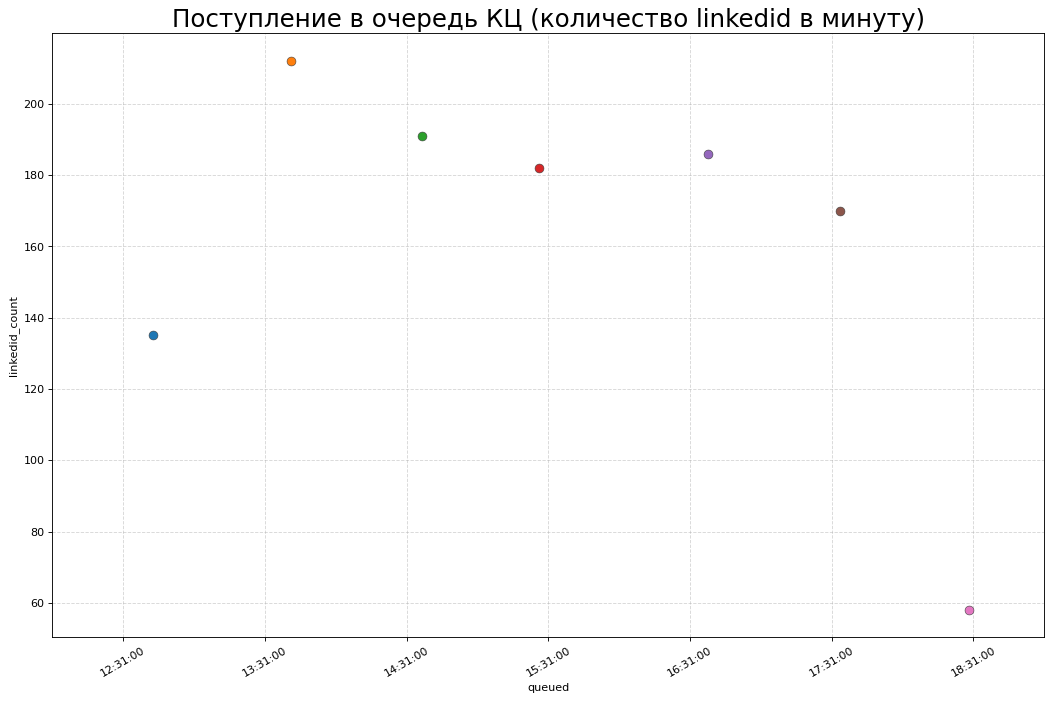

In [60]:
queue_tasks_report(1, 'Поступление в очередь КЦ (количество linkedid в минуту)')

/home/alex/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


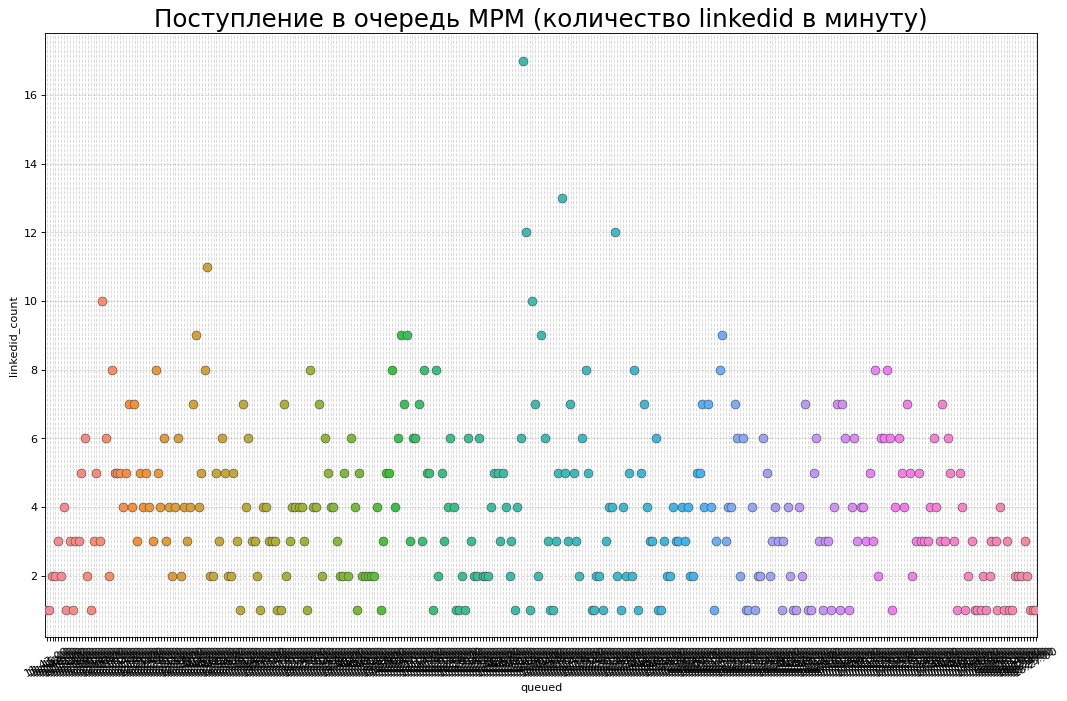

In [61]:
queue_tasks_report(2, 'Поступление в очередь МРМ (количество linkedid в минуту)')